In [19]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

from modelsClassifier import fit_GS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

sns.set_theme(style="whitegrid", palette=None, font_scale=1.2)

figPath = f"/home/skatz/PROJECTS/covid/disease_severity/discoveryValidation/clinical_T1/figures"
os.makedirs(figPath, exist_ok=True)

# Plot AUC-ROC curves using CV

In [2]:
datasetTimepoint = "12_uponAdmission"
target = "disease_severity"
#### Feature selection:
vars = "boruta+bestSterols"    # bestSterols
varPath = f"../../results/featureSelection/{datasetTimepoint}/{vars}.txt"

''' 
Define paths
'''
resultsPath = f"../../results/prediction/featureSelection/{datasetTimepoint}/{vars}/bestEstimator"
os.makedirs(resultsPath, exist_ok=True)
dataPath = "../../results/preprocessing/cleaned"
dataset = f"{datasetTimepoint}_{target}_cleaned.csv"

In [3]:
''' 
Read data
'''
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0)
X_orig = data.drop(target, axis=1)
y_orig = data[target]

########## Additionally split dataset to avoid overfitting ##############
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, stratify=y_orig)
########################

''' 
Read in variables
'''
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()


## ROC-AUC with CV

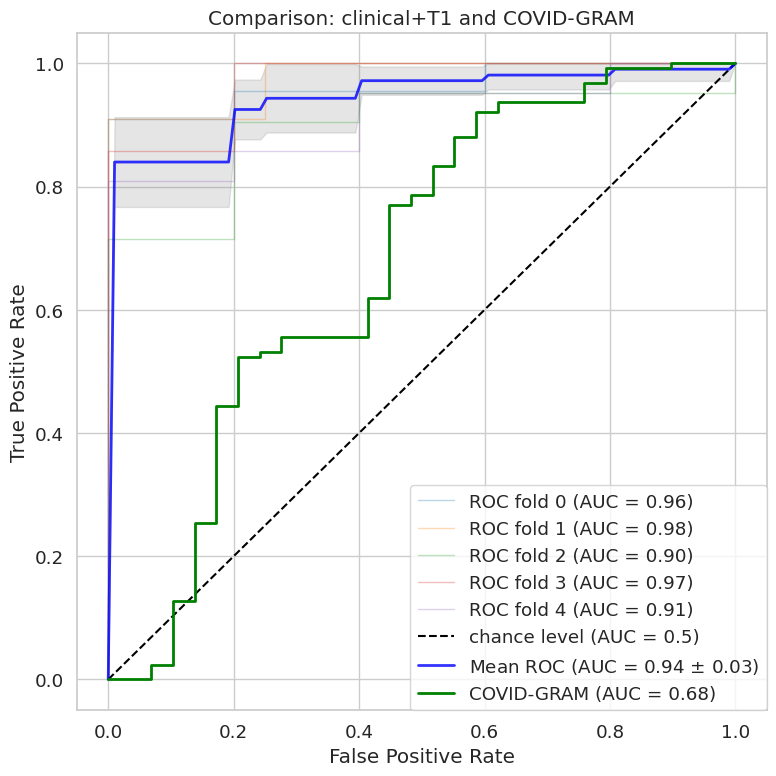

In [20]:
''' 
Run CV ROC AUC
'''
model = "RandomForest"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8,8))
for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf = fit_GS(X_train.iloc[train,:], y_train.iloc[train], target, sel_variables, model, randomState=None)

    viz = RocCurveDisplay.from_estimator(
        clf,
        X_train.iloc[test,:],
        y_train.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    #label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{datasetTimepoint} - {vars}",
)


'''
Add COVID GRAM AUC ROC curve 
'''

with open("/home/skatz/PROJECTS/covid/disease_severity/discoveryValidation/clinical/results/prediction/COVID_GRAM/fpr_tpr_auc.p", "rb") as f: gram_fpr, gram_tpr = pickle.load(f)
gram_roc_auc = auc(gram_fpr, gram_tpr)

ax.plot(gram_fpr, gram_tpr, color='green',
         lw=2, label=f'COVID-GRAM (AUC = %0.2f)' % gram_roc_auc)

''''''

#ax.axis("square")
ax.set_title("Comparison: clinical+T1 and COVID-GRAM")
plt.legend(loc=4, borderaxespad=0)
plt.tight_layout()
plt.savefig(f"{figPath}/AUC_COVID_GRAM.png", dpi=300,  bbox_inches = "tight")
#plt.show()